# Importing dependencies

In [1]:
import pandas as pd
import numpy as np          
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import f1_score  
from sklearn.pipeline import make_pipeline  
from sklearn.impute import SimpleImputer  
import seaborn as sns
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.multioutput import MultiOutputClassifier
import scipy
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score

In [2]:
pd.set_option.max_columns=30

# Reading Data

In [7]:
path = '/Users/alghali/Downloads/AI-Compeitions/WIDS-2025/data'
def read_data(path=path) -> pd.DataFrame : 
    trc=pd.read_excel(f'{path}/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx')
    trq=pd.read_excel(f'{path}/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx')
    trf=pd.read_csv(f'{path}/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv')
    trs=pd.read_excel(f'{path}/TRAIN/TRAINING_SOLUTIONS.xlsx')  
    tsc=pd.read_excel(f'{path}/TEST/TEST_CATEGORICAL.xlsx')
    tsq=pd.read_excel(f'{path}/TEST/TEST_QUANTITATIVE_METADATA.xlsx')    
    tsf=pd.read_csv(f'{path}/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')    
    sub=pd.read_excel(f'{path}/SAMPLE_SUBMISSION.xlsx')    
    dic=pd.read_excel(f'{path}/Data Dictionary.xlsx')
    return trc, trq, trf, trs, tsc, tsq, tsf, sub, dic

trc, trq, trf, trs, tsc, tsq, tsf, sub, dic = read_data(path=path)

In [ ]:
#just formating my categorical data and ensuring it is defined as categorical 
for column in trc.columns: 
    trc[column] = trc[column].astype('object')
    tsc[column] = tsc[column].astype('object')
    #note that "object" == categorical okk?

In [ ]:
for column in trc.columns:
    print(tsc[column].dtype)
    #just making sure it works, we can remove this later

object
object
object
object
object
object
object
object
object
object


# Descriptions

`trq` = quantitative/numerical data features for the trainset

`trc` = categorical data features for the trainset 

`trf` = MRI thing in the trainset

`trs` = the target variables for the trainset 

`tsc` = categorical data features for the trainset

`tsq` = quantitative/numerical data features for the testset

`tsf` = MRI thing for the testset

`sub` = submission file 

`dic` = dictionary of the data



Data Merging 

In [ ]:
cq = pd.merge(trc, trq, on='participant_id', how='left') #we added the quantative data of each data point and merge it with its categorical metadata
feat = pd.merge(cq, trf, on='participant_id', how='left')  # add extra faeatures
qc = pd.merge(tsc, tsq, on='participant_id', how='left') #do the same for the test 
train = pd.merge(feat, trs, on='participant_id', how='left') #add the targets
test = pd.merge(qc, tsf, on='participant_id', how='left')  #add the targets on the test

# EDA

- missing values and duplicates 
- size of train and test 
- distributions 
- target count values 
- co-relations with the heatmap 
- detect outliers 

In [10]:
train.describe()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,58.876917,13.164880,3.781533,13.205276,39.374279,17.785655,16.393240,25.246496,2.059357,12.122836,...,-0.004378,0.001610,0.115171,0.049984,0.058144,0.093527,0.089403,0.128946,0.685078,0.342951
std,49.855501,2.780624,1.376700,3.811772,6.245928,3.764112,5.376994,3.950529,2.023322,6.577207,...,0.042900,0.047424,0.057128,0.051664,0.057674,0.054594,0.058036,0.058490,0.464676,0.474891
min,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.178688,-0.138048,-0.070094,-0.153540,-0.131455,-0.085566,-0.204160,-0.083077,0.000000,0.000000
25%,45.600000,14.000000,3.000000,11.000000,36.000000,16.000000,13.000000,23.000000,0.000000,7.000000,...,-0.033798,-0.030132,0.080291,0.015827,0.022316,0.059621,0.053224,0.090459,0.000000,0.000000
50%,76.670000,14.000000,3.000000,13.000000,40.000000,18.000000,16.000000,26.000000,2.000000,12.000000,...,-0.003724,0.000990,0.113640,0.052705,0.059151,0.093397,0.088612,0.127913,1.000000,0.000000
75%,93.400000,14.000000,4.000000,16.000000,43.000000,20.000000,19.000000,28.000000,3.000000,17.000000,...,0.024007,0.032268,0.150524,0.082526,0.095192,0.127144,0.127613,0.166523,1.000000,1.000000
max,100.000000,14.000000,12.000000,28.000000,50.000000,28.000000,37.000000,30.000000,10.000000,34.000000,...,0.180562,0.192015,0.375635,0.228748,0.322084,0.348153,0.267162,0.414304,1.000000,1.000000


In [11]:
test.describe()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
count,303.000000,295.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,274.000000,274.000000,...,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,59.144488,13.240678,3.321799,13.259516,39.633218,16.726644,15.944637,24.826990,1.890511,11.781022,...,0.049241,-0.055612,-0.015886,0.022734,0.558894,0.353789,0.380367,0.503837,0.487597,0.557431
std,49.330962,1.986273,0.810248,3.627411,5.153586,3.360000,4.931163,3.283666,1.973000,6.056771,...,0.199660,0.225587,0.215424,0.206935,0.156629,0.203452,0.195547,0.170680,0.183347,0.173604
min,-100.050000,0.000000,2.000000,6.000000,20.000000,7.000000,9.000000,10.000000,0.000000,0.000000,...,-0.363454,-0.501310,-0.570880,-0.479486,0.000000,-0.201091,-0.213887,-0.040523,-0.199617,-0.168106
25%,50.060000,13.000000,3.000000,11.000000,36.000000,14.000000,12.000000,23.000000,0.000000,7.000000,...,-0.093097,-0.227949,-0.164278,-0.128828,0.479489,0.235322,0.264928,0.401851,0.377687,0.456239
50%,73.370000,14.000000,3.000000,13.000000,40.000000,17.000000,15.000000,25.000000,1.000000,11.000000,...,0.037098,-0.077162,-0.014110,0.006236,0.577125,0.374062,0.404230,0.539822,0.502269,0.581648
75%,93.380000,14.000000,3.000000,16.000000,43.000000,19.000000,19.000000,28.000000,3.000000,16.000000,...,0.179494,0.100244,0.126558,0.154479,0.662010,0.508747,0.528825,0.627340,0.616772,0.682909
max,100.050000,14.000000,8.000000,23.000000,50.000000,27.000000,31.000000,30.000000,10.000000,29.000000,...,0.737060,0.681016,0.781968,0.809705,0.874170,0.780386,0.765132,0.859924,0.820123,0.872319


- note that there is no way I heave noticed the difference between the train and test distributions of data, the columns are huuuuuge, I'm thinking of writing a functoin that would later help me faciliate the process of detecting different between the train and test distributions in certain variables/features 

In [ ]:
num_feats = [feature for feature in train.columns if train[feature].dtype == 'float64']
cat_feats = [feature for feature in train.columns if train[feature].dtype == 'object']
#I just iterate over all features saving the names of the numberical/quantative feautes in 'num_feats' list and cat feats for categorical features 
len(cat_feats),len(num_feats)

(10, 19902)

In [13]:
cat_feats

['participant_id',
 'Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'MRI_Track_Scan_Location',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ']

In [14]:
pd.set_option.max_rows= 40

In [ ]:
missing_data = ((train.isnull().sum()/ (len(train)) * 100)) # get the ration of missing data in each columns 
missing_data = pd.DataFrame(missing_data, columns=["missing value"])  # transform it to pandas data frame 
missing_data.index.name = "columns"  # set their names as rows in distinct column
missing_data = missing_data.sort_values(by="missing value", ascending=False)  #sorting the value by how bad the missingness is (descending)
missing_data

,missing value
columns,
MRI_Track_Age_at_Scan,29.678483
PreInt_Demos_Fam_Child_Ethnicity,0.906843
Barratt_Barratt_P1_Edu,0.000000
Barratt_Barratt_P1_Occ,0.000000
Barratt_Barratt_P2_Edu,0.000000
...,...
SDQ_SDQ_Externalizing,0.000000
SDQ_SDQ_Generating_Impact,0.000000
SDQ_SDQ_Hyperactivity,0.000000


In [ ]:
# doing the same for the tests because we are democrats 
issing_data = ((test.isnull().sum()/ (len(test)) * 100))
missing_data = pd.DataFrame(missing_data, columns=["missing value"]) 
missing_data.index.name = "columns"  
missing_data = missing_data.sort_values(by="missing value", ascending=False)  
missing_data.head(30)

,missing value
columns,
Barratt_Barratt_P2_Occ,13.815789
Barratt_Barratt_P2_Edu,11.842105
SDQ_SDQ_Generating_Impact,9.868421
SDQ_SDQ_Externalizing,9.868421
SDQ_SDQ_Emotional_Problems,9.868421
SDQ_SDQ_Difficulties_Total,9.868421
SDQ_SDQ_Conduct_Problems,9.868421
SDQ_SDQ_Prosocial,9.868421
SDQ_SDQ_Peer_Problems,9.868421


- we are lucky it turns out that different variables have different Nan rations and locations in different columns, are we?

In [18]:
def null_evaluation(column,set): 
    print('__________________________')
    print (column)
    print('__________________________')
    total = len(set[column])
    missing_values = set[column].isnull().sum()
    missing_percentage = set[column].isnull().mean(axis=0) * 100
    non_null = abs(missing_values - total)
    print('total_values             :', total)
    print('missing_values           :', missing_values)
    print('non null                 :', non_null)
    print('missing value percentage :',missing_percentage)

In [ ]:
print(null_evaluation("MRI_Track_Age_at_Scan",train))
print(null_evaluation("Barratt_Barratt_P2_Occ",test))

#I randomly picked 2 columns to further analyze the missing data (I never did I just printed the code but at least it highlight that around 40 Nans location in the test are up to 14% of data so this is realtivly huge) 

__________________________
MRI_Track_Age_at_Scan
__________________________
total_values             : 1213
missing_values           : 360
non null                 : 853
missing value percentage : 29.67848309975268
None
__________________________
Barratt_Barratt_P2_Occ
__________________________
total_values             : 304
missing_values           : 42
non null                 : 262
missing value percentage : 13.815789473684212
None


In [ ]:
missing_columns_train = [column for column in train.columns if train[column].isnull().any() == True ]
missing_columns_test = [column for column in test.columns if test[column].isnull().any() == True ]
#I'm saving columns names the once with missing values

In [ ]:
all_nulls = []
for column in missing_columns_test:
    null_indices = test[test[column].isnull()].index
    #if null_indices.any() != (0,) and null_indices.any() != (3,):
    for value in null_indices:
        all_nulls.append(value)
    print("_________________________________")
    print(null_indices)
    #what I did is I saved the null/Nans values index on list, I can't recall my exact Idea but I remeber i had something crazy to do with it

_________________________________
Index([49, 77, 89], dtype='int64')
_________________________________
Index([39, 49, 116, 198, 222, 238], dtype='int64')
_________________________________
Index([49], dtype='int64')
_________________________________
Index([49], dtype='int64')
_________________________________
Index([  1,  16,  33,  36,  40,  49,  51,  52,  54,  59,  67,  69,  86,  87,
        89,  98, 109, 120, 127, 130, 131, 146, 149, 156, 177, 181, 189, 204,
       233, 252, 255, 258, 259, 273, 282, 292],
      dtype='int64')
_________________________________
Index([ 16,  33,  36,  39,  40,  44,  49,  51,  52,  59,  67,  69,  86,  87,
        89,  98,  99, 101, 104, 109, 112, 120, 127, 130, 131, 146, 149, 156,
       163, 177, 181, 189, 204, 233, 255, 258, 259, 273, 280, 282, 292, 301],
      dtype='int64')
_________________________________
Index([184], dtype='int64')
_________________________________
Index([55, 68, 74, 114, 167, 191, 192, 286, 298], dtype='int64')
___________________

In [22]:
all_nulls = np.array(all_nulls)
all_nulls.reshape(-1)

array([ 49,  77,  89,  39,  49, 116, 198, 222, 238,  49,  49,   1,  16,
        33,  36,  40,  49,  51,  52,  54,  59,  67,  69,  86,  87,  89,
        98, 109, 120, 127, 130, 131, 146, 149, 156, 177, 181, 189, 204,
       233, 252, 255, 258, 259, 273, 282, 292,  16,  33,  36,  39,  40,
        44,  49,  51,  52,  59,  67,  69,  86,  87,  89,  98,  99, 101,
       104, 109, 112, 120, 127, 130, 131, 146, 149, 156, 163, 177, 181,
       189, 204, 233, 255, 258, 259, 273, 280, 282, 292, 301, 184,  55,
        68,  74, 114, 167, 191, 192, 286, 298,   5,  45,  49,  61,  86,
        87,  90, 140, 156, 162, 174, 196, 208, 220, 270,   5,  45,  49,
        61,  86,  87,  90, 140, 156, 162, 174, 196, 208, 220, 270,   5,
        45,  49,  61,  86,  87,  90, 140, 156, 162, 174, 196, 208, 220,
       270,   5,  45,  49,  61,  86,  87,  90, 140, 156, 162, 174, 196,
       208, 220, 270,   5,  45,  49,  61,  86,  87,  90, 140, 156, 162,
       174, 196, 208, 220, 270,   5,  45,  49,  61,  86,  87,  9

In [ ]:
all_nulls = pd.DataFrame(all_nulls)
all_nulls.value_counts()
#gotcha, I was thinking that if happens and a place of these null accured more than lets say 10 it means multiple columns are missing from one instance so we should drop it. I swear it's my original Idea

0  
49     21
87     17
156    17
196    15
45     15
270    15
174    15
90     15
208    15
5      15
52     11
111     9
152     9
117     9
202     9
172     9
165     9
142     9
113     9
121     9
32      9
75      9
43      9
20      9
63      9
8       9
187     9
246     9
209     9
296     9
86      8
162     6
220     6
140     6
61      6
89      3
33      2
36      2
39      2
67      2
40      2
16      2
292     2
282     2
273     2
233     2
259     2
204     2
69      2
59      2
51      2
131     2
146     2
130     2
120     2
149     2
127     2
98      2
255     2
109     2
177     2
258     2
189     2
181     2
44      1
1       1
74      1
68      1
54      1
55      1
101     1
104     1
114     1
116     1
167     1
163     1
77      1
99      1
112     1
184     1
191     1
192     1
222     1
198     1
238     1
252     1
286     1
280     1
298     1
301     1
Name: count, dtype: int64

In [ ]:
index = list(all_nulls[0].drop_duplicates())
index
# I want the list to contain the numbers only

[49,
 77,
 89,
 39,
 116,
 198,
 222,
 238,
 1,
 16,
 33,
 36,
 40,
 51,
 52,
 54,
 59,
 67,
 69,
 86,
 87,
 98,
 109,
 120,
 127,
 130,
 131,
 146,
 149,
 156,
 177,
 181,
 189,
 204,
 233,
 252,
 255,
 258,
 259,
 273,
 282,
 292,
 44,
 99,
 101,
 104,
 112,
 163,
 280,
 301,
 184,
 55,
 68,
 74,
 114,
 167,
 191,
 192,
 286,
 298,
 5,
 45,
 61,
 90,
 140,
 162,
 174,
 196,
 208,
 220,
 270,
 8,
 20,
 32,
 43,
 63,
 75,
 111,
 113,
 117,
 121,
 142,
 152,
 165,
 172,
 187,
 202,
 209,
 246,
 296]

In [25]:
train.iloc[index]['Sex_F'].value_counts()

Sex_F
0    67
1    23
Name: count, dtype: int64

# targets distributions

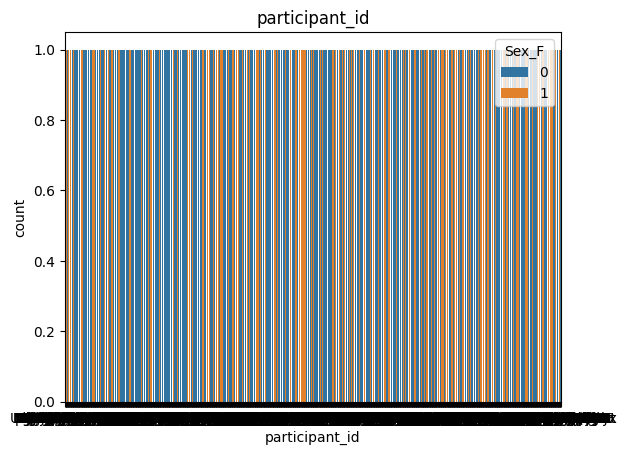

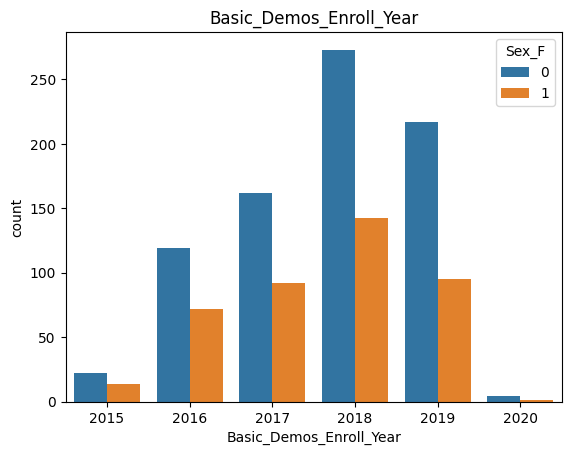

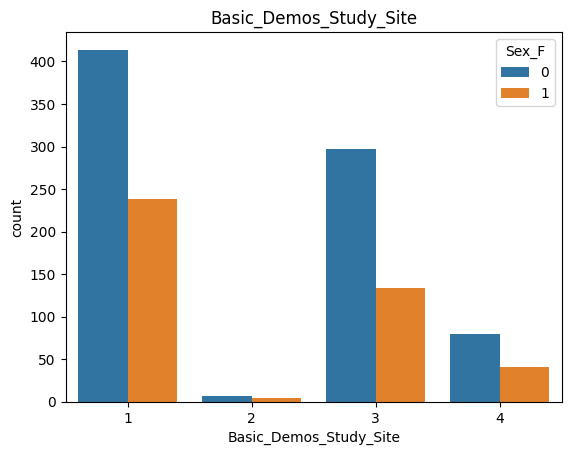

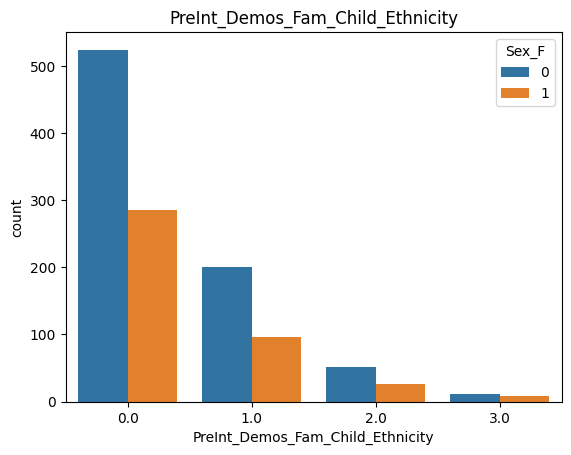

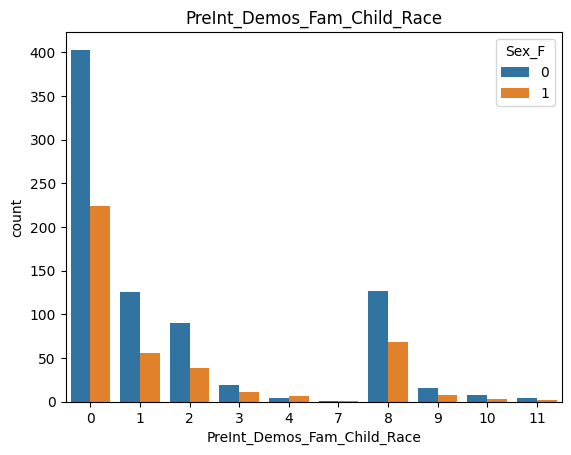

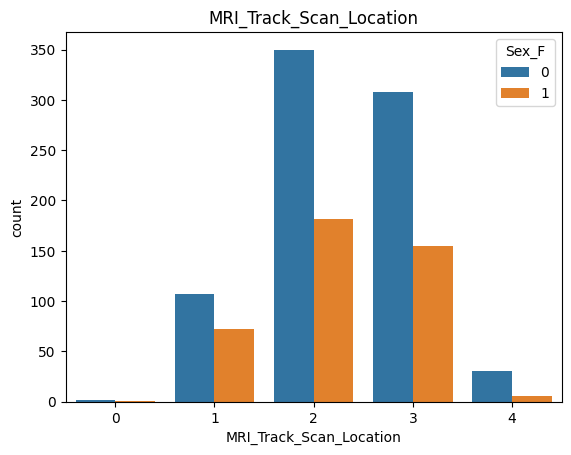

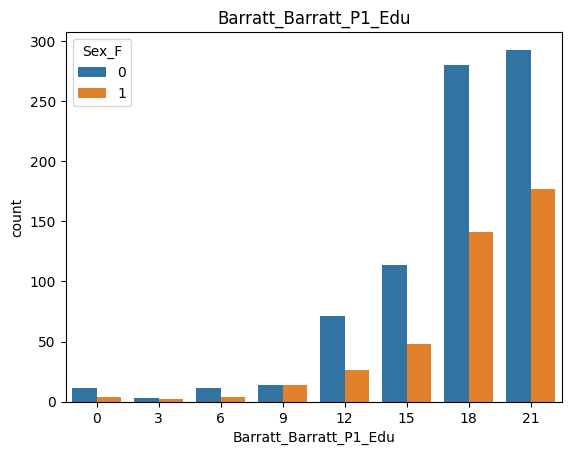

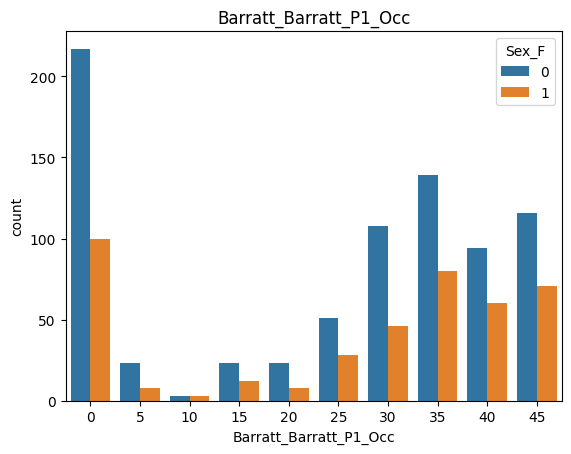

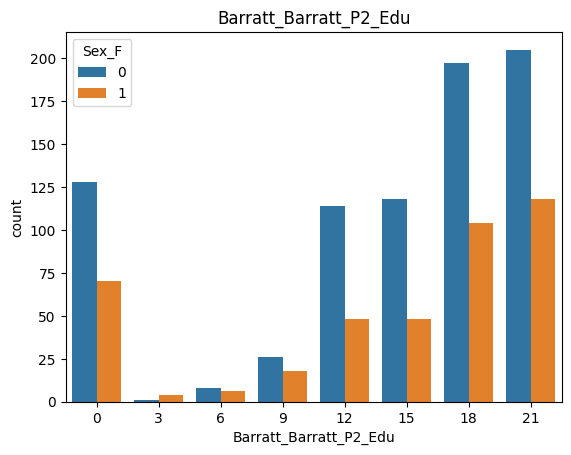

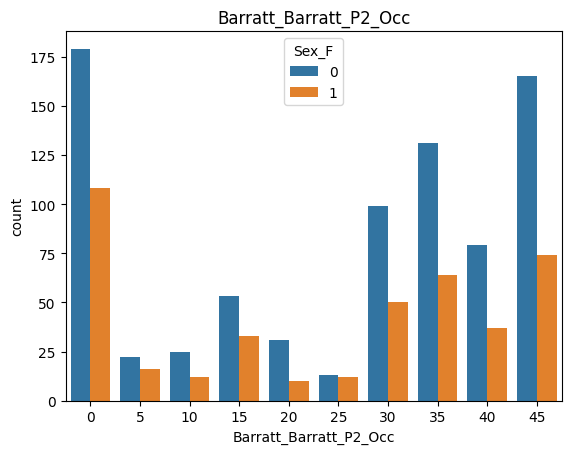

In [ ]:
for col in cat_feats:
    plt.title(col)
    sns.countplot(data=train, x=train[col], hue="Sex_F")
    plt.show()
    #for the sex target the data is reativly suffuled

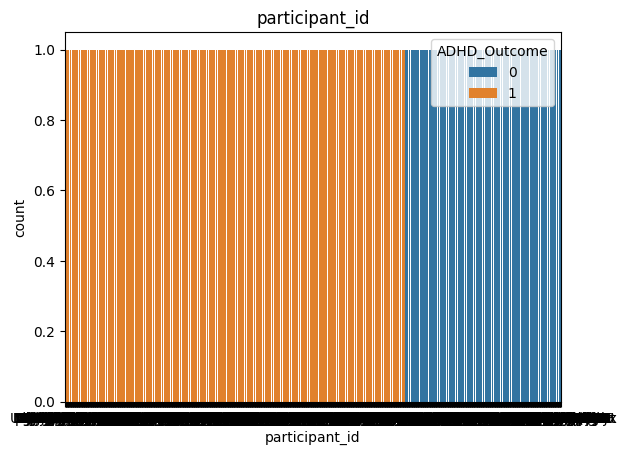

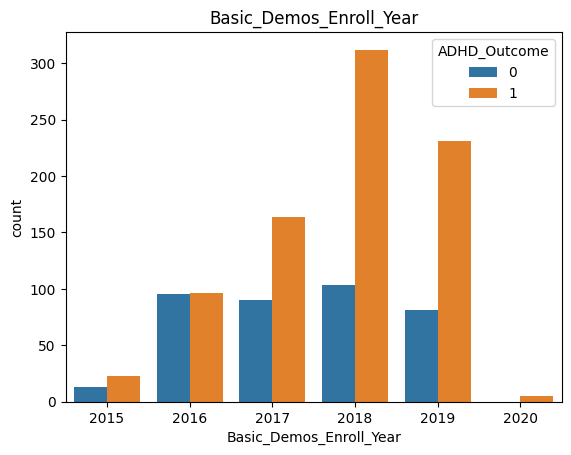

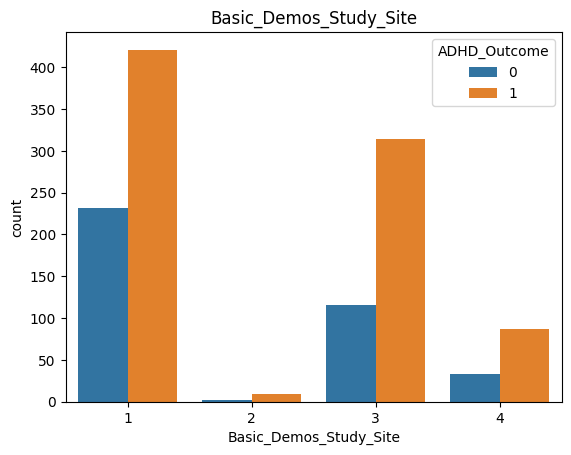

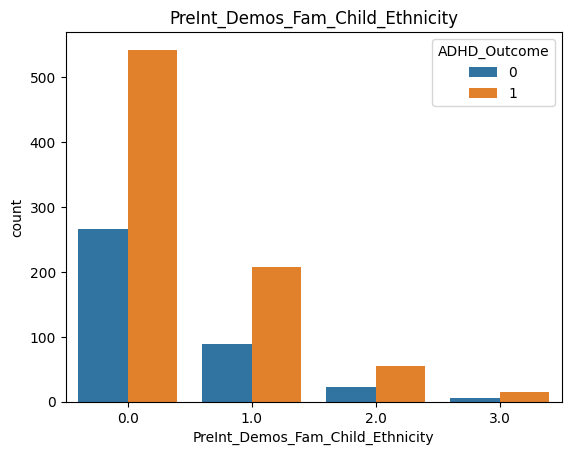

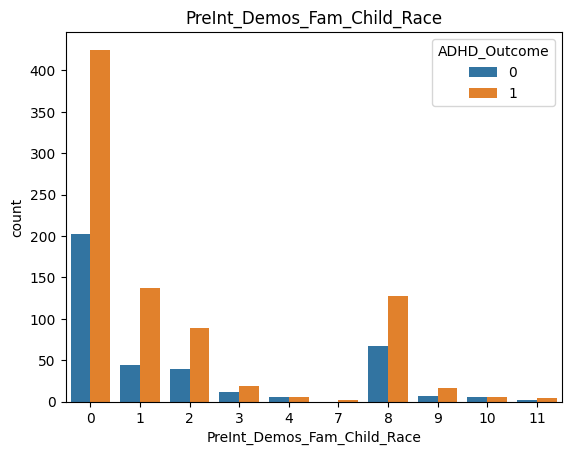

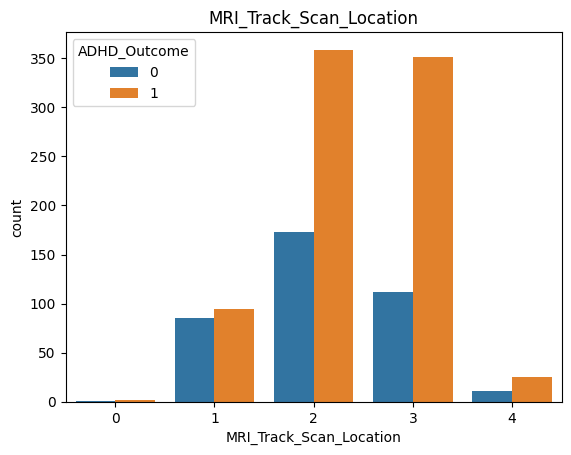

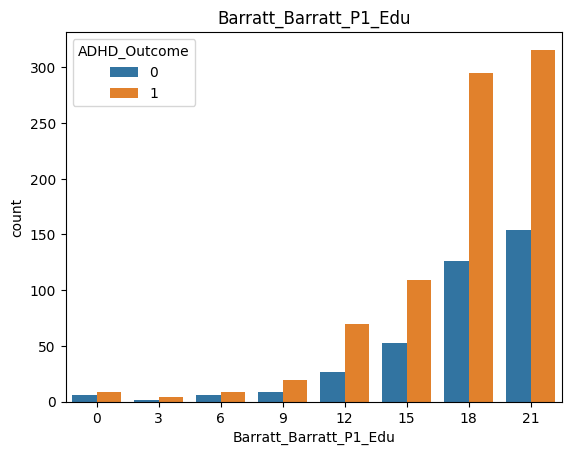

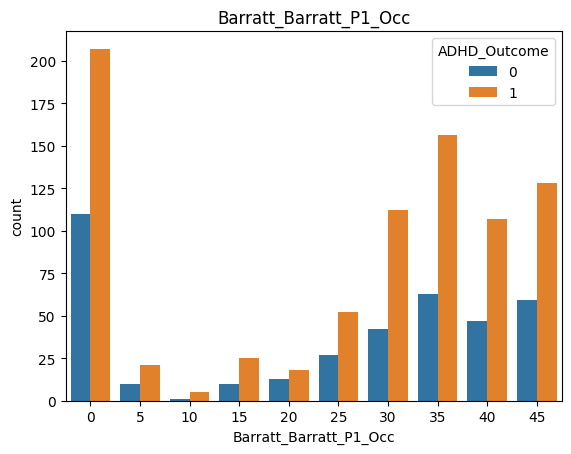

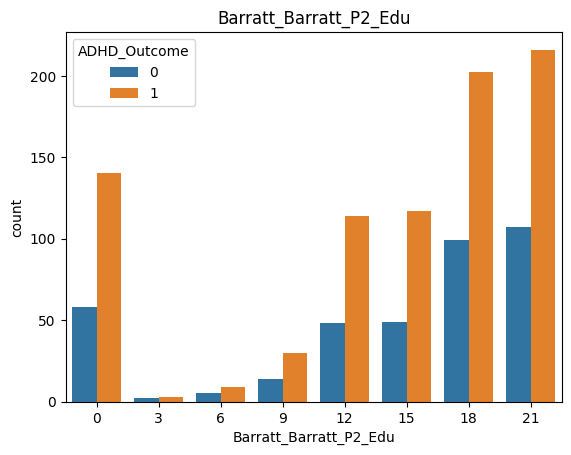

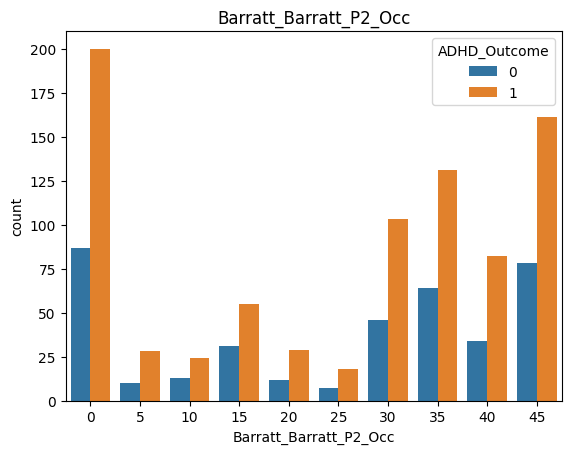

In [ ]:
for col in cat_feats:
    plt.title(col)
    sns.countplot(data=train, x=train[col], hue="ADHD_Outcome")
    plt.show()
    #now here is a pretty lovely graph, the first one, almost the fist 70% is having ADHD and the rest is negative, but what is important is their distribution, we can't use train,test split or group-kfold ofc.

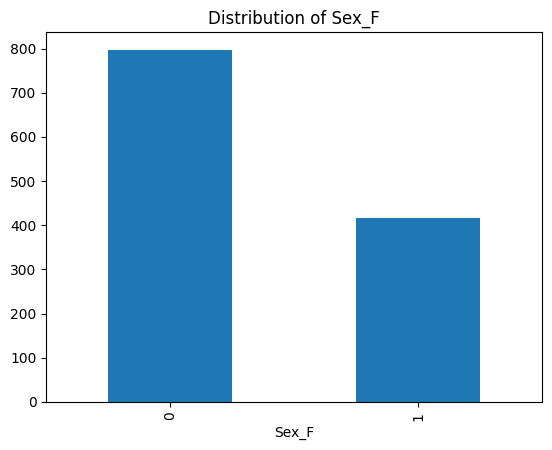

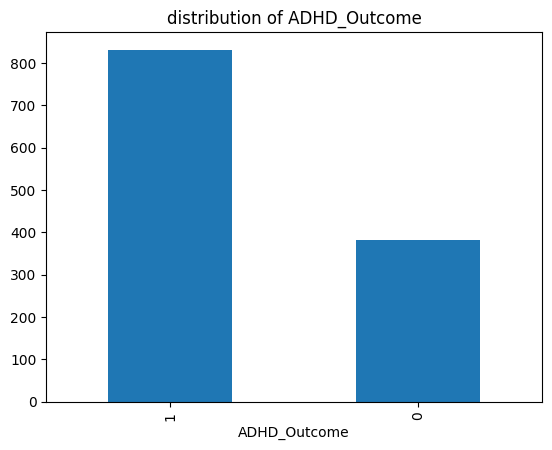

In [33]:
train['Sex_F'].value_counts().plot(kind='bar')
plt.title("Distribution of Sex_F")
plt.show()

train['ADHD_Outcome'].value_counts().plot(kind='bar')
plt.title("distribution of ADHD_Outcome")
plt.show()

<Axes: xlabel='ADHD_Outcome', ylabel='count'>

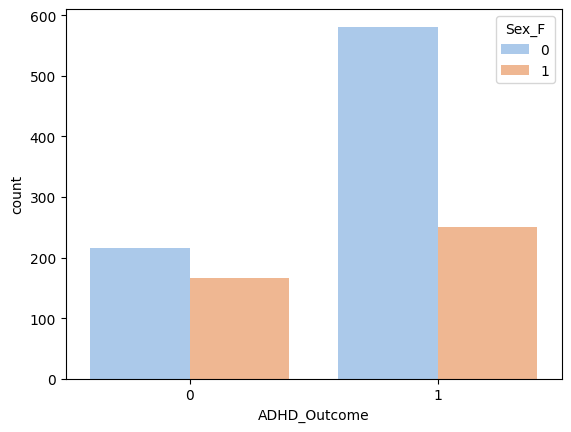

In [ ]:
sns.countplot(data=train, x='ADHD_Outcome', hue='Sex_F',palette='pastel')

In [35]:
for col in cat_feats:
    print(col,train[col].nunique())

participant_id 1213
Basic_Demos_Enroll_Year 6
Basic_Demos_Study_Site 4
PreInt_Demos_Fam_Child_Ethnicity 4
PreInt_Demos_Fam_Child_Race 10
MRI_Track_Scan_Location 5
Barratt_Barratt_P1_Edu 8
Barratt_Barratt_P1_Occ 10
Barratt_Barratt_P2_Edu 8
Barratt_Barratt_P2_Occ 10


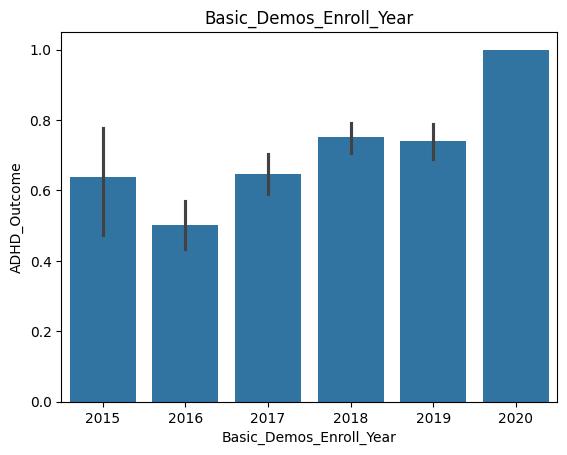

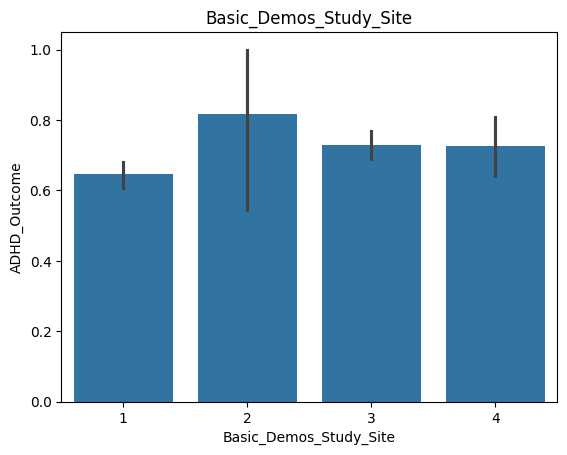

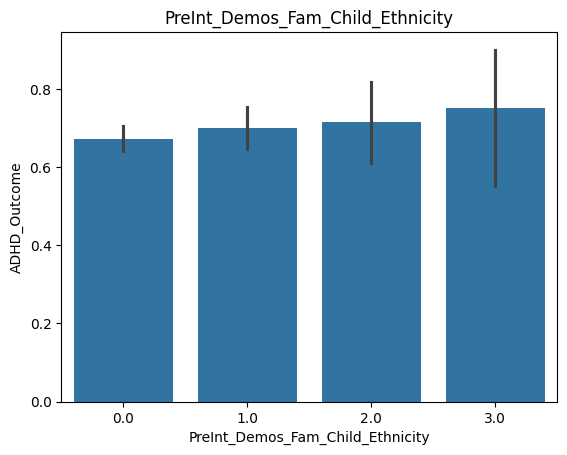

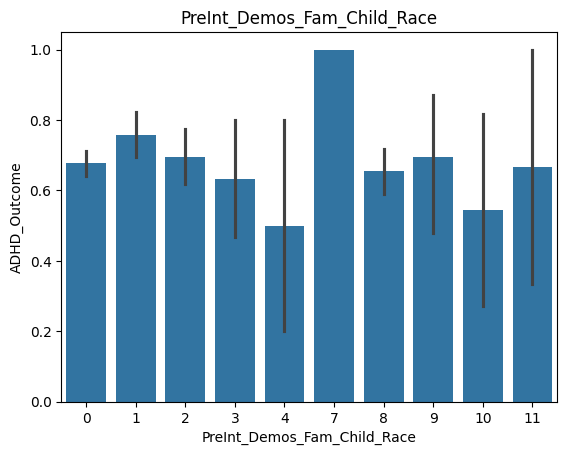

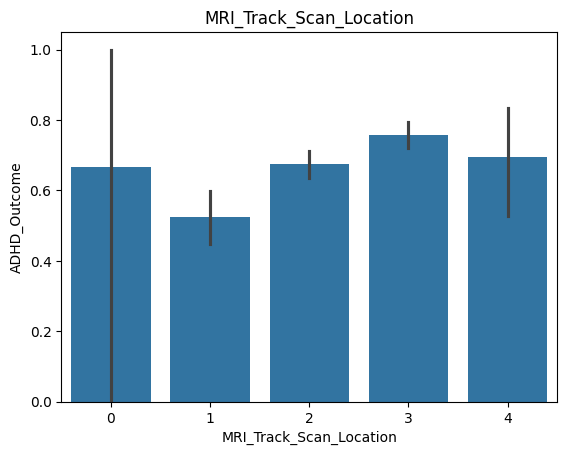

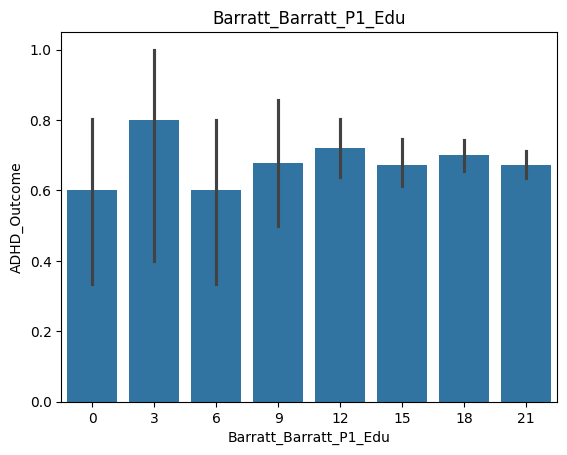

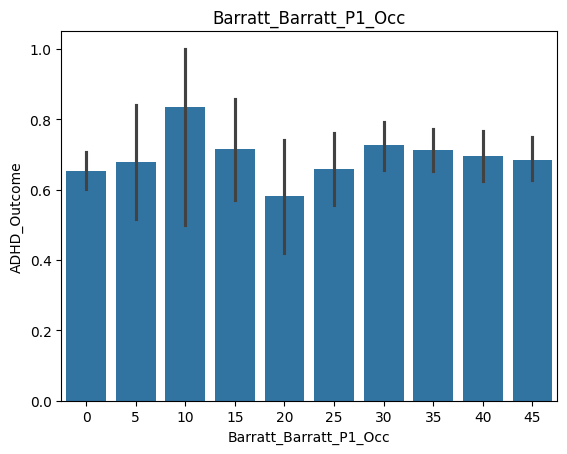

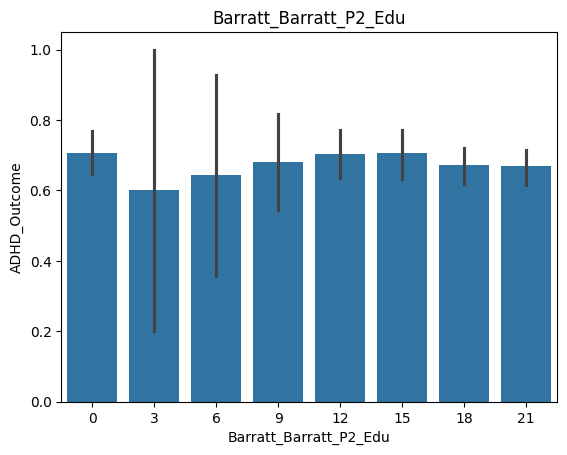

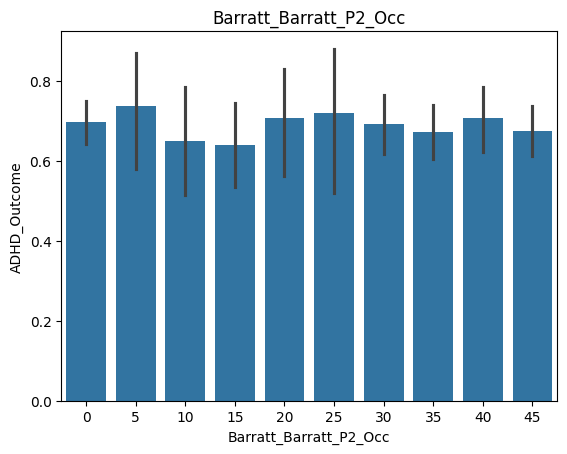

In [36]:
for column in cat_feats:
    if column != "participant_id":
        sns.barplot(train,x=train[column], y=train['ADHD_Outcome'])
        plt.title(column)
        plt.show()

- my assumption is: maybe cutting from men with ADHD will help the model generalize better

In [ ]:
duplicate_count = train.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

duplicate_count = test.duplicated().sum()
print(f"Total duplicate rows test: {duplicate_count}")

Total duplicate rows: 0
Total duplicate rows test: 0


## value counts 

In [ ]:
cat_feats

['participant_id',
 'Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'MRI_Track_Scan_Location',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ']

In [ ]:
for feature in cat_feats:

    print(train[feature].value_counts())
    print("_____________________")

participant_id
k8HhHnnu2wmt    1
UmrK0vMLopoR    1
CPaeQkhcjg7d    1
Nb4EetVPm3gs    1
p4vPhVu91o4b    1
               ..
HoVdS7f0bCJz    1
Vv7IKSukMkhl    1
ozh6v2FJ6R5o    1
9Znie6oQLkEM    1
FrjCLpmemRKk    1
Name: count, Length: 1213, dtype: int64
_____________________
Basic_Demos_Enroll_Year
2018    415
2019    312
2017    254
2016    191
2015     36
2020      5
Name: count, dtype: int64
_____________________
Basic_Demos_Study_Site
1    652
3    430
4    120
2     11
Name: count, dtype: int64
_____________________
PreInt_Demos_Fam_Child_Ethnicity
0.0    809
1.0    296
2.0     77
3.0     20
Name: count, dtype: int64
_____________________
PreInt_Demos_Fam_Child_Race
0     627
8     195
1     181
2     128
3      30
9      23
10     11
4      10
11      6
7       2
Name: count, dtype: int64
_____________________
MRI_Track_Scan_Location
2    532
3    463
1    179
4     36
0      3
Name: count, dtype: int64
_____________________
Barratt_Barratt_P1_Edu
21    470
18    421
15    162
12 

In [ ]:
train[num_feats].max()

columns
EHQ_EHQ_Total            100.000000
MRI_Track_Age_at_Scan     21.564453
0throw_1thcolumn           0.321522
0throw_2thcolumn           0.390895
0throw_3thcolumn           0.278429
                            ...    
196throw_198thcolumn       0.228748
196throw_199thcolumn       0.322084
197throw_198thcolumn       0.348153
197throw_199thcolumn       0.267162
198throw_199thcolumn       0.414304
Length: 19902, dtype: float64

In [ ]:
train[num_feats].describe()

columns,EHQ_EHQ_Total,MRI_Track_Age_at_Scan,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,0throw_11thcolumn,0throw_12thcolumn,0throw_13thcolumn,0throw_14thcolumn,0throw_15thcolumn,0throw_16thcolumn,0throw_17thcolumn,0throw_18thcolumn,0throw_19thcolumn,0throw_20thcolumn,0throw_21thcolumn,0throw_22thcolumn,0throw_23thcolumn,0throw_24thcolumn,0throw_25thcolumn,0throw_26thcolumn,0throw_27thcolumn,0throw_28thcolumn,0throw_29thcolumn,0throw_30thcolumn,0throw_31thcolumn,0throw_32thcolumn,0throw_33thcolumn,0throw_34thcolumn,0throw_35thcolumn,0throw_36thcolumn,0throw_37thcolumn,0throw_38thcolumn,...,190throw_196thcolumn,190throw_197thcolumn,190throw_198thcolumn,190throw_199thcolumn,191throw_192thcolumn,191throw_193thcolumn,191throw_194thcolumn,191throw_195thcolumn,191throw_196thcolumn,191throw_197thcolumn,191throw_198thcolumn,191throw_199thcolumn,192throw_193thcolumn,192throw_194thcolumn,192throw_195thcolumn,192throw_196thcolumn,192throw_197thcolumn,192throw_198thcolumn,192throw_199thcolumn,193throw_194thcolumn,193throw_195thcolumn,193throw_196thcolumn,193throw_197thcolumn,193throw_198thcolumn,193throw_199thcolumn,194throw_195thcolumn,194throw_196thcolumn,194throw_197thcolumn,194throw_198thcolumn,194throw_199thcolumn,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
count,1213.000000,853.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,58.876917,11.245678,0.060553,0.122315,0.060268,0.041287,0.069722,0.091007,0.066852,0.000252,0.014128,-0.002914,0.023445,-0.000025,0.003497,-0.001103,-0.001764,-0.001823,0.003157,0.003641,-0.002395,0.002833,0.003530,0.001866,0.001889,-0.000287,0.005968,0.002858,-0.003472,0.036919,0.062763,0.016129,0.009390,-0.002431,0.003276,0.001031,0.000354,-0.003742,-0.001083,0.001123,...,0.093495,0.050054,0.025502,0.002741,0.040979,0.014379,-0.014017,-0.005663,0.000982,0.012796,0.011619,-0.003734,0.001870,-0.005900,-0.004697,0.035542,0.049185,0.048282,0.022127,0.059630,0.026731,0.005676,-0.008964,0.024466,0.010422,0.085035,0.015047,-0.004274,0.001083,0.007412,0.011075,-0.004938,-0.004378,0.001610,0.115171,0.049984,0.058144,0.093527,0.089403,0.128946
std,49.855501,3.234372,0.064178,0.054026,0.057495,0.043491,0.044222,0.049189,0.046864,0.049046,0.038205,0.042462,0.043274,0.040053,0.034549,0.036259,0.035653,0.035889,0.037132,0.037854,0.038207,0.042437,0.036721,0.041470,0.033895,0.039686,0.037078,0.032638,0.034017,0.045374,0.045424,0.043852,0.035823,0.033267,0.036481,0.032197,0.032423,0.035457,0.036298,0.036265,...,0.056554,0.051441,0.047880,0.049327,0.044135,0.038854,0.035292,0.039961,0.039638,0.042231,0.041902,0.038029,0.035701,0.035728,0.042882,0.048197,0.049116,0.046264,0.046802,0.044949,0.045019,0.040211,0.037863,0.043856,0.041283,0.049776,0.042052,0.038663,0.041826,0.043275,0.049632,0.046536,0.042900,0.047424,0.057128,0.051664,0.057674,0.054594,0.0580

0.2784285594648653
-0.1455663102947689


<Axes: >

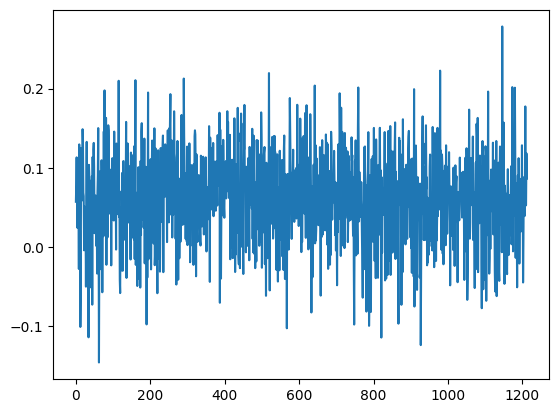

In [ ]:
print(train['0throw_3thcolumn'].max())
print(train['0throw_3thcolumn'].min())
train['0throw_3thcolumn'].plot()

#shall we amplify these values or we smoothen it?

In [ ]:
outliers_max_train = ['0throw_1thcolumn','0throw_3thcolumn']

# Data Preprocessing

- drop useless features 

- haandle misssing values 

- extract feaatures and amplify or smoothen features 

- target encoding and encoding 

- stratifiy with the combination of targets 

In [51]:
Targets = ['ADHD_Outcome','Sex_F']

<Axes: xlabel='count'>

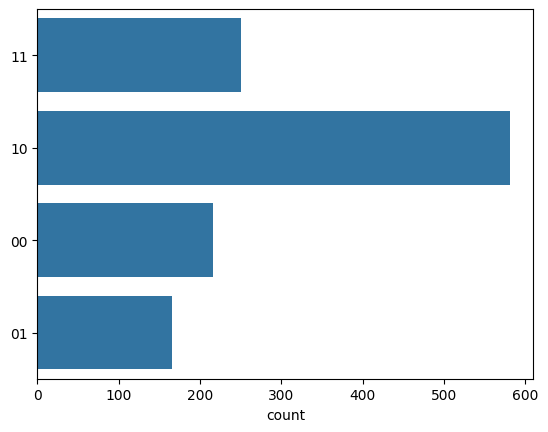

In [62]:
startified_outcomes = trs["ADHD_Outcome"].astype('str') + trs['Sex_F'].astype("str")
startified_outcomes
sns.countplot(data=startified_outcomes)

In [ ]:

for feature in cat_feats:
    contingency_table = pd.crosstab(train[feature], train['ADHD_Outcome'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    print(f"Chi-square test statistic:{feature} {chi2}, p-value: {p}")


Chi-square test statistic:participant_id 1213.0, p-value: 0.48650002651560253
Chi-square test statistic:Basic_Demos_Enroll_Year 46.94471972972127, p-value: 5.830819392127769e-09
Chi-square test statistic:Basic_Demos_Study_Site 10.538325388025893, p-value: 0.014503155035049294
Chi-square test statistic:PreInt_Demos_Fam_Child_Ethnicity 1.6416362923894505, p-value: 0.6499863473663159
Chi-square test statistic:PreInt_Demos_Fam_Child_Race 9.180644389788181, p-value: 0.42076912834741986
Chi-square test statistic:MRI_Track_Scan_Location 32.94559960216587, p-value: 1.225508832910079e-06
Chi-square test statistic:Barratt_Barratt_P1_Edu 2.8623149056928927, p-value: 0.8974403235496908
Chi-square test statistic:Barratt_Barratt_P1_Occ 6.1938746253793555, p-value: 0.7203686249507641
Chi-square test statistic:Barratt_Barratt_P2_Edu 1.9626603953037396, p-value: 0.9618780622181727
Chi-square test statistic:Barratt_Barratt_P2_Occ 2.533324993753509, p-value: 0.9799737943546775


In [ ]:
drop_columns = ["Basic_Demos_Study_Site", "PreInt_Demos_Fam_Child_Race","MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity"]
second_degree_drop = ["PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ']]

In [ ]:
encoder = LabelEncoder()
for column in cat_feats:
    if column == "participant_id": 
        train[column] = encoder.fit_transform(train[column])
        test[column] = encoder.fit_transform(test[column])

In [80]:
def encode_categoricals(df):
    df = df.copy()
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col])
    return df



In [81]:
train = encode_categoricals(train)
test = encode_categoricals(test)

# Training and Validation

In [93]:
targets = ['ADHD_Outcome','Sex_F']

In [96]:
target_cols = ['ADHD_Outcome', 'Sex_F']
groups = train['participant_id']
n_splits = 5 
cv = StratifiedGroupKFold(n_splits=n_splits)

base_model = LGBMClassifier(random_state=SEED)
model = MultiOutputClassifier(base_model)


features = test.columns

log_features = [f for f in features if (train[f] >= 0).all() and scipy.stats.skew(train[f]) > 0]

model = MultiOutputClassifier(make_pipeline(ColumnTransformer([('imputer',SimpleImputer(),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                                            MinMaxScaler(),  
                                            PCA(970),
                                            RidgeClassifier(alpha=100)))



def validate(trainset, testset, target_cols):
    model.fit(trainset.drop(columns=target_cols), trainset[target_cols])
    pred = model.predict(testset.drop(columns=target_cols))
    valid_idx = testset[target_cols].notna().all(axis=1)
    
    valid_testset = testset.loc[valid_idx, target_cols]
    valid_pred = pred[valid_idx]
    f1_scores = [f1_score(valid_testset[col], valid_pred[:, i]) for i, col in enumerate(target_cols)]
    
    print(f"F1-scores per target: {dict(zip(target_cols, f1_scores))}")
    
    return f1_scores


stds = []
F1s = []

for train_index, test_index in cv.split(train.drop(columns=target_cols), train[target_cols[0]], groups=groups): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    
    stds.append(test_v[target_cols].std())
    F1s.append(validate(train_v, test_v, target_cols))

F1s = np.array(F1s)

print("Mean F1-scores per target:", F1s.mean(axis=0))
print("F1-score stds per target:", F1s.std(axis=0))
print("Standard deviations of test sets:", stds)


F1-scores per target: {'ADHD_Outcome': 0.8268733850129198, 'Sex_F': 0.4}
F1-scores per target: {'ADHD_Outcome': 0.841025641025641, 'Sex_F': 0.37254901960784315}
F1-scores per target: {'ADHD_Outcome': 0.8202531645569621, 'Sex_F': 0.29411764705882354}
F1-scores per target: {'ADHD_Outcome': 0.8481675392670157, 'Sex_F': 0.34615384615384615}
F1-scores per target: {'ADHD_Outcome': 0.8402061855670103, 'Sex_F': 0.39655172413793105}
Mean F1-scores per target: [0.83530518 0.36187445]
F1-score stds per target: [0.01019649 0.03900805]
Standard deviations of test sets: [columns
ADHD_Outcome    0.466218
Sex_F           0.480409
dtype: float64, columns
ADHD_Outcome    0.464573
Sex_F           0.472377
dtype: float64, columns
ADHD_Outcome    0.466218
Sex_F           0.475213
dtype: float64, columns
ADHD_Outcome    0.465098
Sex_F           0.468331
dtype: float64, columns
ADHD_Outcome    0.465098
Sex_F           0.480850
dtype: float64]


In [ ]:
    """
    base = F1-scores per target: {'ADHD_Outcome': 0.8676056338028169, 'Sex_F': 0.2376237623762376}
    using PCA wit the base Mean F1-scores per target: [0.83530518 0.36187445]
    """

 Convert the scales of social factors variables

# Inference and Submission

In [ ]:
model.fit(train.drop(columns=["ADHD_Outcome","Sex_F"],axis=1),
          trs.drop('participant_id',axis=1))
y_pred = model.predict(test)
sub['ADHD_Outcome'] = 1 # y_pred[:,0]
sub['Sex_F'] = y_pred[:,1]
sub.to_csv(f'../submissions/submission{f1_score}.csv',index=False)